## How to work with Climate Adaptation Digital Twin data on Earth Data Hub: high resolution fields on a single level or surface

***
This notebook will provide you guidance on how to access and use the [`https://data.earthdatahub.com/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr`](https://earthdatahub.com/collections/d1-climate-dt-ScenarioMIP-SSP3-7.0-IFS-NEMO/datasets/0001-high-sfc) datset on [Earth Data Hub](https://earthdatahub.com).
***
### What you will learn:
* how to access and preview the dataset
* select and reduce the data
* plot the results
***
Our first goal is to plot the mean 2 metre temperature in January 2025 over Central Europe.

Our second goal is to compute the 2 metre temperature climatology (monthly means and standard deviations) in Berlin for the 2020-2025 reference period.

### Data access and preview
***

[Xarray](https://docs.xarray.dev/en/stable) and [Dask](https://www.dask.org) work together following a lazy principle. This means when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. A smart user will reduce the amount of data that needs to be downloaded before the computation takes place (e.g., when the `.compute()` or `.plot()` methods are called).

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically:

***

In [1]:
import xarray as xr

ds = xr.open_dataset(
    "https://data.earthdatahub.com/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr",
    chunks={},
    engine="zarr",
    storage_options={"client_kwargs": {"trust_env": True}},
)
ds

<xarray.Dataset> Size: 169TB
Dimensions:    (time: 157800, latitude: 4096, longitude: 8193)
Coordinates:
  * latitude   (latitude) float64 33kB -90.0 -89.96 -89.91 ... 89.91 89.96 90.0
  * longitude  (longitude) float64 66kB -180.0 -180.0 -179.9 ... 180.0 180.0
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 1MB 2020-01-01 ... 2037-12-31T23:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 21TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    sd         (time, latitude, longitude) float32 21TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ssr        (time, latitude, longitude) float32 21TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    str        (time, latitude, longitude) float32 21TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 21TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    tprate     (time, latitude, longitude) float32 21TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 21TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 21TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-06-05T09:09 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

### Working with EDH data

Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment. 

The structure of an EDH workflow looks like this:
1. data selection
2. (optional) data reduction
3. (optional) visualization

### Average 2 metre temperature in Germany, January 2025

#### 1. Data selection

First, we perform a geographical selection corresponding to the Germany area. This greatly reduces the amount of data that will be downloaded from EDH. Also, we convert the temperature to `°C`.

In [2]:
t2m = ds.t2m.astype("float32") - 273.15
t2m.attrs["units"] = "C"
t2m_germany_area = t2m.sel(**{"latitude": slice(47, 55), "longitude": slice(5, 16)})
t2m_germany_area

<xarray.DataArray 't2m' (time: 157800, latitude: 182, longitude: 251)> Size: 29GB
dask.array<getitem, shape=(157800, 182, 251), dtype=float32, chunksize=(48, 182, 251), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 1kB 47.01 47.05 47.1 ... 54.88 54.92 54.97
  * longitude  (longitude) float64 2kB 5.01 5.054 5.098 ... 15.91 15.95 16.0
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 1MB 2020-01-01 ... 2037-12-31T23:00:00
Attributes:
    units:    C

!NB: At this point, no data has been downloaded yet, nor loaded in memory.

Second, we further select January 2025. This is again a lazy operation:

In [3]:
t2m_germany_area_january_2025 = t2m_germany_area.sel(time="2025-01")
t2m_germany_area_january_2025

<xarray.DataArray 't2m' (time: 744, latitude: 182, longitude: 251)> Size: 136MB
dask.array<getitem, shape=(744, 182, 251), dtype=float32, chunksize=(48, 182, 251), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 1kB 47.01 47.05 47.1 ... 54.88 54.92 54.97
  * longitude  (longitude) float64 2kB 5.01 5.054 5.098 ... 15.91 15.95 16.0
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 6kB 2025-01-01 ... 2025-01-31T23:00:00
Attributes:
    units:    C

At this point the selection is small enough to call `.compute()` on it. This will trigger the download of data from EDH and load it in memory. 

We can measure the time it takes:

In [4]:
%%time

t2m_germany_area_january_2025 = t2m_germany_area_january_2025.compute()

CPU times: user 3.07 s, sys: 940 ms, total: 4.01 s
Wall time: 37.5 s


The data was very small, this didn't take long.

#### 2. Data reduction

Now that the data is loaded in memory, we can easily compute the october 2023 monthly mean:

In [5]:
t2m_germany_area_january_2025_monthly_mean = t2m_germany_area_january_2025.mean(dim="time")
t2m_germany_area_january_2025_monthly_mean

<xarray.DataArray 't2m' (latitude: 182, longitude: 251)> Size: 183kB
array([[-0.8969761 , -0.8969761 , -0.8025547 , ..., -3.1368895 ,
        -3.1368895 , -2.6983926 ],
       [-0.8969761 , -1.0263447 , -0.82204366, ..., -3.1355457 ,
        -3.1355457 , -2.7975185 ],
       [-1.0263447 , -1.1123666 , -1.1123666 , ..., -3.1355457 ,
        -3.3344598 , -2.7975185 ],
       ...,
       [ 1.8563639 ,  1.8563639 ,  1.842923  , ..., -1.0532222 ,
        -1.1358839 , -1.1358839 ],
       [ 1.842923  ,  1.842923  ,  1.842923  , ..., -1.0253322 ,
        -0.9917299 , -1.1053058 ],
       [ 1.8066328 ,  1.8066328 ,  1.8066328 , ..., -0.9917299 ,
        -0.9917299 , -1.0616227 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 1kB 47.01 47.05 47.1 ... 54.88 54.92 54.97
  * longitude  (longitude) float64 2kB 5.01 5.054 5.098 ... 15.91 15.95 16.0
    step       timedelta64[ns] 8B 00:00:00
    surface    float64 8B 0.0

#### 3. Visualization
Finally, we can plot the monthly mean of January 2029 on a map:

In [6]:
import display
import matplotlib.pyplot as plt

<GeoAxes: title={'center': 'Mean Surface Temperature, Jan 2025'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

/Users/nicola/opt/miniconda3/envs/edh/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/nicola/opt/miniconda3/envs/edh/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/nicola/opt/miniconda3/envs/edh/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


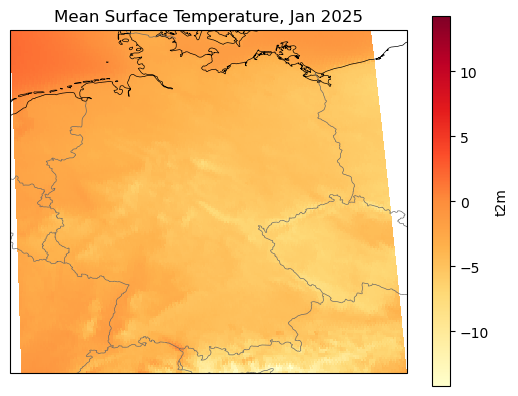

In [7]:
display.map(t2m_germany_area_january_2025_monthly_mean, vmax=None, cmap="YlOrRd", title="Mean Surface Temperature, Jan 2025")

### 2 metre temperature climatology in Berlin, 2020-2035 

We will now compute the 2 metre temperature climatology (montly mean and standard deviation) in Berlin for the reference period 2020-2035.

We first select the closet data to Berlin:

In [8]:
%%time

t2m_Berlin_2020_2035 = t2m.sel(**{"latitude": 52.5, "longitude": 13.4}, method="nearest").sel(time=slice("2020", "2035"))
t2m_Berlin_2020_2035

CPU times: user 68.2 ms, sys: 33.6 ms, total: 102 ms
Wall time: 16.9 ms


<xarray.DataArray 't2m' (time: 140256)> Size: 561kB
dask.array<getitem, shape=(140256,), dtype=float32, chunksize=(48,), chunktype=numpy.ndarray>
Coordinates:
    latitude   float64 8B 52.51
    longitude  float64 8B 13.4
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 1MB 2020-01-01 ... 2035-12-31T23:00:00
Attributes:
    units:    C

This is already small enought to be computed:

In [9]:
%%time

t2m_Berlin_2020_2035 = t2m_Berlin_2020_2035.compute()

CPU times: user 8min 30s, sys: 2min 9s, total: 10min 40s
Wall time: 1h 4min 48s


Now that the data is loaded in memory we can easily compute the climatology:

In [10]:
t2m_Berlin_climatology_mean = t2m_Berlin_2020_2035.groupby("time.month").mean(dim="time")
t2m_Berlin_climatology_std = t2m_Berlin_2020_2035.groupby("time.month").std(dim="time")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


We can finally plot the climatology in Berlin for the 2020-2030 refrence period

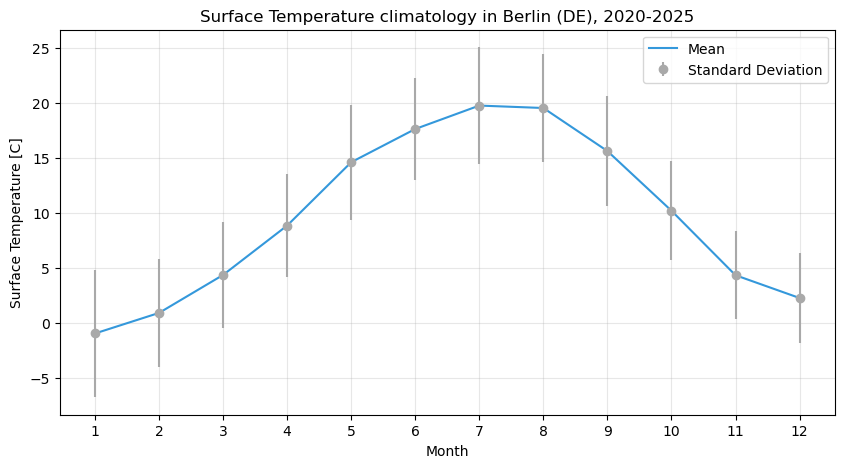

In [11]:
plt.figure(figsize=(10, 5))
t2m_Berlin_climatology_mean.plot(label="Mean", color="#3498db")
plt.errorbar(
    t2m_Berlin_climatology_mean.month, 
    t2m_Berlin_climatology_mean, 
    yerr=t2m_Berlin_climatology_std, 
    fmt="o", 
    label="Standard Deviation",
    color="#a9a9a9"
)

plt.title("Surface Temperature climatology in Berlin (DE), 2020-2025")
plt.xticks(t2m_Berlin_climatology_mean.month)
plt.xlabel("Month")
plt.ylabel("Surface Temperature [C]")
plt.legend()
plt.grid(alpha=0.3)
plt.show()